$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\cset}[1]{\mathcal{#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\E}[2][]{\mathbb{E}_{#1}\left[#2\right]}
\newcommand{\given}[]{~\middle\vert~}
$$

# CS236605: Deep Learning
# Tutorial 8: Geometric deep learning

## Introduction

In this tutorial, we will cover:

TODO

In [618]:
# Setup
%matplotlib inline
import os
import sys
import math
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'running on: {device}')

running on: cpu


## Theory Reminders: Non-euclidean domains

In [619]:
plt.cm.Accent

## Part 1: Vanilla GCN

From [Wikipedia](https://en.wikipedia.org/wiki/Zachary%27s_karate_club),

A social network of a karate club was studied by Wayne W. Zachary for a period of three years from 1970 to 1972.

The network captures 34 members of a karate club, documenting links between pairs of members who interacted outside the club. During the study a conflict arose between the **administrator** "John A" and **instructor** "Mr. Hi" (pseudonyms), which led to the split of the club into two. Half of the members formed a new club around Mr. Hi; members from the other part found a new instructor or gave up karate. Based on collected data Zachary correctly assigned all but one member of the club to the groups they actually joined after the split. 


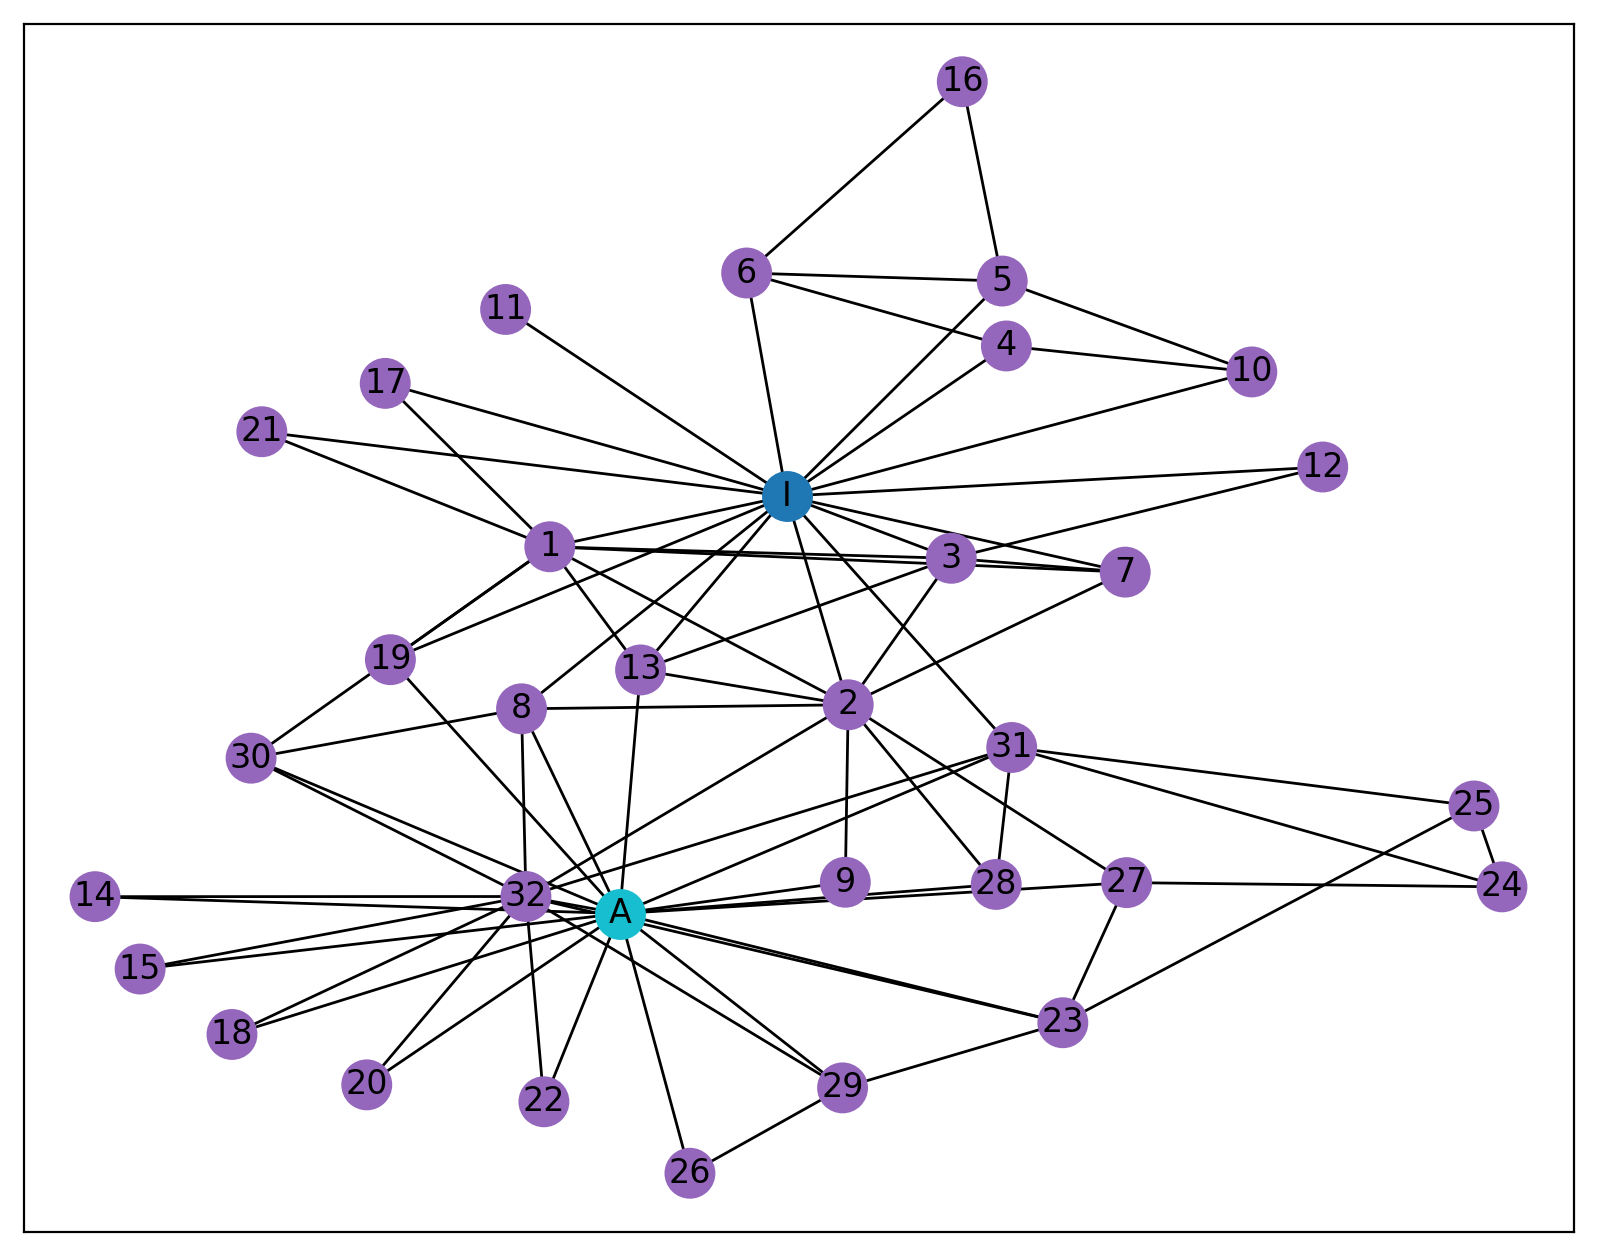

In [634]:
import networkx as nx

G = nx.karate_club_graph()
ID_INSTR = 0
ID_ADMIN = 33
ID_MEMBERS = set(G.nodes()) - set([ID_ADMIN, ID_INSTR])

# Draw graph
node_pos = nx.kamada_kawai_layout(G)

plt.subplots(1,1, figsize=(10,8), dpi=200)
cmap = dict(cmap=plt.cm.tab10, vmin=0, vmax=1)

nx.draw_networkx_nodes(G, node_pos, nodelist=[ID_INSTR], node_color=(0.,), **cmap)
nx.draw_networkx_nodes(G, node_pos, nodelist=[ID_ADMIN], node_color=(1.,), **cmap)
nx.draw_networkx_nodes(G, node_pos, nodelist=ID_MEMBERS, node_color=(0.4,)*len(ID_MEMBERS), **cmap)
nx.draw_networkx_edges(G, node_pos)

node_labels = {i: i for i in ID_MEMBERS}
node_labels.update({i: l for i,l in zip([ID_ADMIN, ID_INSTR],['A','I'])})
nx.draw_networkx_labels(G, node_pos, labels=node_labels);


In [635]:
# Create ground-truth labels
labels = [(0 if d['club']=='Mr. Hi' else 1) for i,d in G.nodes().data()]
labels = torch.tensor(labels, dtype=torch.long)

# Labels represent group affiliation
list(G.nodes().data())

[(0, {'club': 'Mr. Hi'}),
 (1, {'club': 'Mr. Hi'}),
 (2, {'club': 'Mr. Hi'}),
 (3, {'club': 'Mr. Hi'}),
 (4, {'club': 'Mr. Hi'}),
 (5, {'club': 'Mr. Hi'}),
 (6, {'club': 'Mr. Hi'}),
 (7, {'club': 'Mr. Hi'}),
 (8, {'club': 'Mr. Hi'}),
 (9, {'club': 'Officer'}),
 (10, {'club': 'Mr. Hi'}),
 (11, {'club': 'Mr. Hi'}),
 (12, {'club': 'Mr. Hi'}),
 (13, {'club': 'Mr. Hi'}),
 (14, {'club': 'Officer'}),
 (15, {'club': 'Officer'}),
 (16, {'club': 'Mr. Hi'}),
 (17, {'club': 'Mr. Hi'}),
 (18, {'club': 'Officer'}),
 (19, {'club': 'Mr. Hi'}),
 (20, {'club': 'Officer'}),
 (21, {'club': 'Mr. Hi'}),
 (22, {'club': 'Officer'}),
 (23, {'club': 'Officer'}),
 (24, {'club': 'Officer'}),
 (25, {'club': 'Officer'}),
 (26, {'club': 'Officer'}),
 (27, {'club': 'Officer'}),
 (28, {'club': 'Officer'}),
 (29, {'club': 'Officer'}),
 (30, {'club': 'Officer'}),
 (31, {'club': 'Officer'}),
 (32, {'club': 'Officer'}),
 (33, {'club': 'Officer'})]

In [636]:
# Adjacency
A = nx.adj_matrix(G, weight=None)
A = np.array(A.todense())

# Add self-loops
A = A + I

# Degree matrix
dii = np.sum(A, axis=1, keepdims=False)
D = np.diag(dii)

# Normalized Laplacian
D_inv_h = np.diag(dii**(-0.5))
L = np.matmul(D_inv_h, np.matmul(A, D_inv_h))

In [637]:
L

array([[0.05882353, 0.0766965 , 0.07312724, ..., 0.09166985, 0.        ,
        0.        ],
       [0.0766965 , 0.1       , 0.09534626, ..., 0.        , 0.        ,
        0.        ],
       [0.07312724, 0.09534626, 0.09090909, ..., 0.        , 0.0836242 ,
        0.        ],
       ...,
       [0.09166985, 0.        , 0.        , ..., 0.14285714, 0.10482848,
        0.08908708],
       [0.        , 0.        , 0.0836242 , ..., 0.10482848, 0.07692308,
        0.06537205],
       [0.        , 0.        , 0.        , ..., 0.08908708, 0.06537205,
        0.05555556]])

In [638]:
import torch.nn as nn

class GCNLayer(nn.Module):
    def __init__(self, graph_L, in_features, out_features, max_deg=1):
        super().__init__()
        self.graph_L = graph_L
        
        self.fc_layers = []
        for i in range(max_deg):
            fc = nn.Linear(in_features, out_features, bias=(i==max_deg-1))
            self.add_module(f'fc_{i}', fc)
            self.fc_layers.append(fc)
        
    def forward(self, X):
        Z = torch.tensor(0.)
        L = self.graph_L
        
        for fc in self.fc_layers:
            LX = torch.mm(L, X)
            Z = fc(LX) + Z
            L = torch.mm(L, self.graph_L)
        
        return torch.relu(Z)

In [683]:
torch.manual_seed(44)

# Input features will be one-hot vectors (no actual info conveyed)
X = torch.eye(G.number_of_nodes())
# X = torch.randn(G.number_of_nodes(), 64)

in_features, out_features = X.shape[1], 2
graph_L = torch.tensor(L, dtype=torch.float)
max_deg = 2

hidden_dim = 10
gcn2 = nn.Sequential(
    GCNLayer(graph_L, in_features, hidden_dim, max_deg),
    GCNLayer(graph_L, hidden_dim, out_features, max_deg),
    nn.LogSoftmax(dim=1)
)
gcn2

Sequential(
  (0): GCNLayer(
    (fc_0): Linear(in_features=34, out_features=10, bias=False)
    (fc_1): Linear(in_features=34, out_features=10, bias=True)
  )
  (1): GCNLayer(
    (fc_0): Linear(in_features=10, out_features=2, bias=False)
    (fc_1): Linear(in_features=10, out_features=2, bias=True)
  )
  (2): LogSoftmax()
)

In [684]:
import torch.nn.functional as F
import torch.optim

optimizer = torch.optim.Adam(gcn2.parameters(), lr=0.01)

all_logits = []
for epoch in range(100):
    logits = gcn2(X)
    all_logits.append(logits.detach())
    # we only compute loss for node 0 and node 33
    loss = F.nll_loss(logits[[ID_ADMIN, ID_INSTR]], labels[[ID_ADMIN, ID_INSTR]])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.6951
Epoch 10 | Loss: 0.5179
Epoch 20 | Loss: 0.2929
Epoch 30 | Loss: 0.1080
Epoch 40 | Loss: 0.0343
Epoch 50 | Loss: 0.0138
Epoch 60 | Loss: 0.0076
Epoch 70 | Loss: 0.0051
Epoch 80 | Loss: 0.0039
Epoch 90 | Loss: 0.0032


In [687]:
# Visualize the node classification using the logits output.
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(dpi=100)
fig.clf()
ax = fig.subplots()
nx_G = G
def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = np.argmax(pos[v])
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw(nx_G.to_undirected(), pos, node_color=colors, with_labels=True, node_size=500)

ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=100)
html = HTML(ani.to_html5_video())
plt.close()
html

In [686]:
from sklearn.metrics import classification_report

y_pred = torch.argmax(gcn2(X), dim=1).numpy()
y = labels.numpy()

print(classification_report(y, y_pred, target_names=['I','A']))

              precision    recall  f1-score   support

           I       1.00      0.94      0.97        17
           A       0.94      1.00      0.97        17

    accuracy                           0.97        34
   macro avg       0.97      0.97      0.97        34
weighted avg       0.97      0.97      0.97        34



**Image credits**

Some images in this tutorial were taken and/or adapted from:

- foo